# Mirando dentro de la caja negra
## Interpretabilidad de modelos de machine learning

## Rodrigo Parra
### @rparrapy
### rodrigo@codium.com.py

## ¿Interpretabilidad?

> Interpretability is the degree to which a human can understand the cause of a decision.

Miller, Explanation in Artificial Intelligence: Insights from the Social Sciences (2017)

## ¿Por qué?

![curiosidad](images/xkcd.png)


### Curiosidad

![curiosidad](images/curiosity.jpg)


### Seguridad
![seguridad](images/security.jpg)


### Detección de sesgo
![sesgo](images/bias.jpg)


### Aceptación social

![social](images/social.jpg)


### Auditoría

![auditoria](images/auditoria.jpeg)


## ¿Cómo?
![auditoria](images/taxonomy.jpg)


### Antes
#### Análisis exploratorio de datos

![eda](images/eda-2.jpg)

### Durante
#### Regresión Lineal

![linear](images/linear.png)

![linear-formula](images/linear-formula.jpg)

### Después
#### Modelos locales subrogados

1. Entrenamos un modelo de caja negra con $x$ e $y$ : $f(x)=\hat{y}$ 
1. Entrenamos un modelo de caja negra con $x$ e $\hat{y}$ : $g(x)=\bar{y}$

![surrogate](images/surrogate.jpg)

## Local interpretable model-agnostic explanations (LIME)

![lime](images/lime.jpg)

# ~~Mirando dentro de~~ Explicando la caja negra
## Interpretabilidad de modelos de machine learning

>  LEARNING = REPRESENTATION + EVALUATION + OPTIMIZATION

Domingos, A Few Useful Things to Know about Machine Learning (2012)

#### Representación
- Modelo de caja negra: no nos importa
- Modelo interpretable: regresión lineal, árboles de decisión, etc.

#### Evaluación
![lime](images/lime-optimal.jpg)

#### Evaluación (2)
![lime](images/lime-cost-4.jpg)

### Optimización

- Modelo de caja negra: descenso de gradiente estocástico 
- Modelo interpretable: mínimos cuadrados, suponiendo que usamos regresión lineal

![lime](images/math-meme.png)

### El algoritmo de LIME

![lime](images/lime-algoritmo.jpg)

### Una imagen vale más que mil palabras

![lime](images/lime-figura.jpg)

### O dos

![lime](images/lime-dog.png)

![lime](images/show-code.jpg)

## Un problema de ejemplo
https://www.youtube.com/watch?v=ACmydtFDTGs

In [1]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_data_dir = './seefood/train'
test_data_dir = './seefood/test'
img_height = 150
img_width = 150
batch_size = 32
nb_train_samples = 498
epochs = 10

Using TensorFlow backend.


In [2]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
for i, batch in enumerate(train_datagen.flow_from_directory(train_data_dir, batch_size=1,
                          save_to_dir='preview', save_prefix='seefood', save_format='jpeg')):
    if i > 5:
        break  # otherwise the generator would loop indefinitely

Found 498 images belonging to 2 classes.


<table><tr><td><img src='preview/seefood_4_3412.jpeg'></td><td><img src='preview/seefood_5_8254.jpeg'></td></tr></table>

In [4]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

Found 498 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [5]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [6]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

# train the model on the new data for a few epochs
model.fit_generator(train_generator, steps_per_epoch=nb_train_samples // batch_size, epochs=epochs)

Epoch 1/10
15/15 [==============================] - 31s - loss: 3.5979 - acc: 0.5104    
Epoch 2/10
15/15 [==============================] - 29s - loss: 0.8257 - acc: 0.5742    
Epoch 3/10
15/15 [==============================] - 28s - loss: 0.7806 - acc: 0.6057    
Epoch 4/10
15/15 [==============================] - 31s - loss: 0.6183 - acc: 0.6898    
Epoch 5/10
15/15 [==============================] - 32s - loss: 0.6111 - acc: 0.7366    
Epoch 6/10
15/15 [==============================] - 29s - loss: 0.6115 - acc: 0.7028    
Epoch 7/10
15/15 [==============================] - 27s - loss: 0.6381 - acc: 0.6913    
Epoch 8/10
15/15 [==============================] - 31s - loss: 0.5884 - acc: 0.7321    
Epoch 9/10
15/15 [==============================] - 27s - loss: 0.6233 - acc: 0.7205    
Epoch 10/10
15/15 [==============================] - 27s - loss: 0.6118 - acc: 0.7180    


In [7]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
#for i, layer in enumerate(base_model.layers):
#   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [8]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])


# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(train_generator, 
                    steps_per_epoch=nb_train_samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=nb_train_samples // batch_size)

Epoch 1/10
15/15 [==============================] - 72s - loss: 0.6945 - acc: 0.6646 - val_loss: 0.5509 - val_acc: 0.7208
Epoch 2/10
15/15 [==============================] - 67s - loss: 0.4518 - acc: 0.8034 - val_loss: 0.4088 - val_acc: 0.8162
Epoch 3/10
15/15 [==============================] - 64s - loss: 0.4542 - acc: 0.8019 - val_loss: 0.4133 - val_acc: 0.8056
Epoch 4/10
15/15 [==============================] - 65s - loss: 0.4249 - acc: 0.8165 - val_loss: 0.4347 - val_acc: 0.7863
Epoch 5/10
15/15 [==============================] - 81s - loss: 0.4547 - acc: 0.7822 - val_loss: 0.4304 - val_acc: 0.8034
Epoch 6/10
15/15 [==============================] - 66s - loss: 0.4305 - acc: 0.7691 - val_loss: 0.4041 - val_acc: 0.8034
Epoch 7/10
15/15 [==============================] - 68s - loss: 0.4286 - acc: 0.8044 - val_loss: 0.3946 - val_acc: 0.8226
Epoch 8/10
15/15 [==============================] - 65s - loss: 0.4258 - acc: 0.8175 - val_loss: 0.4212 - val_acc: 0.8056
Epoch 9/10
15/15 [======

In [4]:
import numpy as np
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
%matplotlib inline


def explain_random_img():
    explainer = lime_image.LimeImageExplainer()
    for i, batch in enumerate(test_datagen.flow_from_directory(test_data_dir, batch_size=1)):
        predictions = model.predict(np.array(batch[0]), batch_size=1)
        print train_generator.class_indices
        print predictions
        explanation = explainer.explain_instance(np.array(batch[0][0]), model.predict, hide_color=0, num_samples=100)
        temp, mask = explanation.get_image_and_mask(np.argmax(predictions[0]), positive_only=False, num_features=5, hide_rest=False)
        plt.axis('off')
        plt.imshow(mark_boundaries(temp, mask))
        break

Found 500 images belonging to 2 classes.
{'hot_dog': 0, 'not_hot_dog': 1}
[[ 0.63319862  0.36680141]]


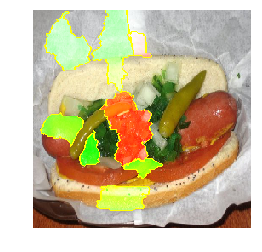

In [10]:
explain_random_img()

Found 500 images belonging to 2 classes.
{'hot_dog': 0, 'not_hot_dog': 1}
[[ 0.4753949  0.5246051]]


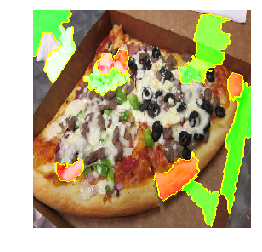

In [11]:
explain_random_img()

Found 500 images belonging to 2 classes.
{'hot_dog': 0, 'not_hot_dog': 1}
[[ 0.42328399  0.57671601]]


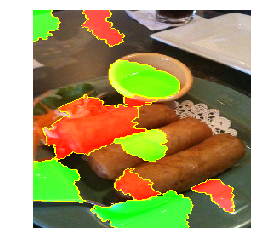

In [12]:
explain_random_img()

Found 500 images belonging to 2 classes.
{'hot_dog': 0, 'not_hot_dog': 1}
[[ 0.50185859  0.49814141]]


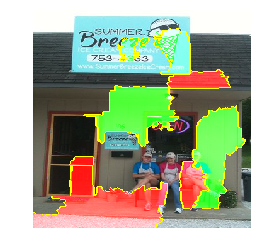

In [13]:
explain_random_img()

Found 500 images belonging to 2 classes.
{'hot_dog': 0, 'not_hot_dog': 1}
[[ 0.64006436  0.35993561]]


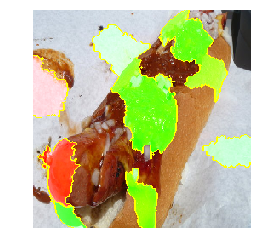

In [14]:
explain_random_img()

Found 500 images belonging to 2 classes.
{'hot_dog': 0, 'not_hot_dog': 1}
[[ 0.51114428  0.48885566]]


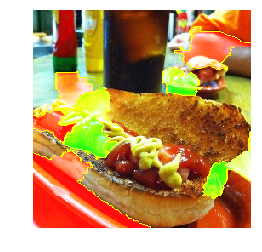

In [17]:
explain_random_img()

Found 500 images belonging to 2 classes.
{'hot_dog': 0, 'not_hot_dog': 1}
[[ 0.60501683  0.3949832 ]]


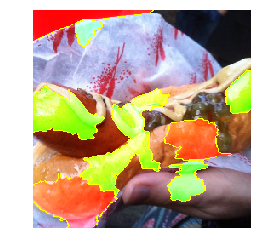

In [16]:
explain_random_img()

## Un ejemplo con Imagenet

![lime](images/lime-cat-1.png)

![lime](images/lime-cat-2.png)

## Referencias

- https://github.com/marcotcr/lime
- https://christophm.github.io/interpretable-ml-book/interpretability.html
- http://people.csail.mit.edu/beenkim/papers/BeenK_FinaleDV_ICML2017_tutorial.pdf
- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- https://betterexplained.com/articles/colorized-math-equations/
- https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog
- https://xkcd.com/1838/
- https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf